<a href="https://colab.research.google.com/github/Andrey22154/electricity-consumption-prediction/blob/main/_electricity_consumption_prediction_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
data = pd.read_excel('/content/mine_data.xlsx')

In [ ]:
data

,/DateTime/Power/Haulage_speed/Traffic_flow
0,0/2020-09-11 00:00:00/458.11//2423.0
1,1/2020-09-11 00:00:05/458.11/8.46/2440.0
2,2/2020-09-11 00:00:10/458.11/8.45/2453.0
3,3/2020-09-11 00:00:15/458.11/8.4/2463.0
4,4/2020-09-11 00:00:20/484.66/9.01/2483.0
...,...
1048570,1048570/2020-11-10 16:20:50/0.0/0.0/386.0
1048571,1048571/2020-11-10 16:20:55/0.0/0.0/396.0
1048572,1048572/2020-11-10 16:21:00/0.0/0.0/389.0
1048573,1048573/2020-11-10 16:21:05/0.0/0.0/388.0


Так как наши данные представляют из себя единый столбец, в котором происходит деление по "/", то необходимо разбить их по этим самым слэшам. 

In [ ]:
data['DateTime'] = data['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(1)
data['Power'] = data['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(2)
data['Haulage_speed'] = data['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(3)
data['Traffic_flow'] = data['/DateTime/Power/Haulage_speed/Traffic_flow'].str.split('/').str.get(4)
data.drop(['/DateTime/Power/Haulage_speed/Traffic_flow'], axis = 1, inplace = True)

In [ ]:
data

,DateTime,Power,Haulage_speed,Traffic_flow
0,2020-09-11 00:00:00,458.11,,2423.0
1,2020-09-11 00:00:05,458.11,8.46,2440.0
2,2020-09-11 00:00:10,458.11,8.45,2453.0
3,2020-09-11 00:00:15,458.11,8.4,2463.0
4,2020-09-11 00:00:20,484.66,9.01,2483.0
...,...,...,...,...
1048570,2020-11-10 16:20:50,0.0,0.0,386.0
1048571,2020-11-10 16:20:55,0.0,0.0,396.0
1048572,2020-11-10 16:21:00,0.0,0.0,389.0
1048573,2020-11-10 16:21:05,0.0,0.0,388.0


Данные разделены. Теперь следует проверить на наличие проущенных значений.
Видно, что в признаке "Haulage_speed" первое значение отсутствует. Его заменим следующим. 

In [ ]:
data.isna().sum()

DateTime         0
Power            0
Haulage_speed    0
Traffic_flow     0
dtype: int64

In [ ]:
'''Замена первого пропуска'''

data['Haulage_speed'][0] = data['Haulage_speed'][1]

In [ ]:
'''Приводим к нужным типам данных'''

data['DateTime'] = data['DateTime'].apply(np.datetime64)
data['Power'] = data['Power'].apply(np.float64)
data['Traffic_flow'] = data['Traffic_flow'].apply(np.float64)
data['Haulage_speed'] = data['Haulage_speed'].apply(np.float64)

In [ ]:
'''Выделяем 3 смены за первый день работы, чтобы вывести графики'''

first_change = data.query("'2020-09-11 00:00:00' <= DateTime < '2020-09-11 09:00:00'")
second_change = data.query("'2020-09-11 09:00:00' <= DateTime < '2020-09-11 17:00:00'")
third_change = data.query("'2020-09-11 17:00:00' <= DateTime < '2020-09-11 00:00:00'")

In [1]:
# Смена 1
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=first_change["DateTime"], y=first_change["Power"], mode = 'lines+markers', name='Мощность',
#                         line = dict(color='#FF66FF', width=2)))
#fig.add_trace(go.Scatter(x=first_change["DateTime"], y=first_change["Haulage_speed"], mode = 'lines+markers', name='Скорость',
#                         line = dict(color='#009900', width=2)))
#fig.add_trace(go.Scatter(x=first_change["DateTime"], y=first_change["Traffic_flow"], mode = 'lines+markers', name='Грузопереток',
#                         line = dict(color='#5346ff', width=2)))
#fig.show()
# Смена 2
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=second_change["DateTime"], y=second_change["Power"], mode = 'lines+markers', name='Мощность',
#                         line = dict(color='#FF66FF', width=2)))
#fig.add_trace(go.Scatter(x=second_change["DateTime"], y=second_change["Haulage_speed"], mode = 'lines+markers', name='Скорость',
#                         line = dict(color='#009900', width=2)))
#fig.add_trace(go.Scatter(x=second_change["DateTime"], y=second_change["Traffic_flow"], mode = 'lines+markers', name='Грузопереток',
#                         line = dict(color='#5346ff', width=2)))
#fig.show()
# Смена 3
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=third_change["DateTime"], y=third_change["Power"], mode = 'lines+markers', name='Мощность',
#                         line = dict(color='#FF66FF', width=2)))
#fig.add_trace(go.Scatter(x=third_change["DateTime"], y=third_change["Haulage_speed"], mode = 'lines+markers', name='Скорость',
#                         line = dict(color='#009900', width=2)))
#fig.add_trace(go.Scatter(x=third_change["DateTime"], y=third_change["Traffic_flow"], mode = 'lines+markers', name='Грузопереток',
#                         line = dict(color='#5346ff', width=2)))
#fig.show()

Как видно из графика, есть аномальные данные, то есть данные, которых быть не может. Например наличие мощности при отсутствии скорости. Такие данные нужно удалить.
Необходмо сохранить дату в отдельную переменную, так как при удалении аномалий, все строки удалятся. Чтобы избежать разрывов, будем подставлять целый временной ряд. В нашем случае, зависимости переменных от времени нет - очистной комбайн одинаково может как работать, так и не работать в любую смену, поэтому любая "перестановка" данных в любой момент времени являетя нормой 

In [ ]:
data_time = data['DateTime']

'''Удаляем по индексу'''

dd_1 = data.query("Haulage_speed == 0 & Power > 0 or Haulage_speed == 0 & Traffic_flow != 0")
data = data.drop(index = dd_1.index)

In [ ]:
data['DateTime'] = data_time
data = data.dropna()

In [ ]:
#data.index = range(0, 575237)
data = data[data['Power'] < 750]
#data.index = range(0, 575211)

In [ ]:
data.index = range(0, 575211)

In [ ]:
data.index = data.DateTime
data = data.drop(['DateTime'], axis = 1)
Working_Shift_1 = data.between_time('09:00:00', '16:59:59') # Смена 1
Working_Shift_2 = data.between_time('17:00:00', '00:59:59') # Смена 2
Working_Shift_3 = data.between_time('01:00:00', '08:59:59') # Смена 3

In [ ]:
data['DateTime'] = data.index

In [ ]:
Working_Shift_1['work_time'] = 1
Working_Shift_2['work_time'] = 2
Working_Shift_3['work_time'] = 3

<ipython-input-18-3b7069cfb27e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-3b7069cfb27e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-3b7069cfb27e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df = pd.concat([Working_Shift_1, Working_Shift_2, Working_Shift_3], axis = 0).sort_values('DateTime')

In [ ]:
df['target'] = df.Power.shift(-17280)
df = df.dropna()

In [ ]:
df['Power_1'] = df.Power.shift(1)
df['Power_2'] = df.Power.shift(2)
df['Power_3'] = df.Power.shift(3)
df['Power_4'] = df.Power.shift(4)
df['Power_5'] = df.Power.shift(5)

In [ ]:
df

,Power,Haulage_speed,Traffic_flow,work_time,target,Power_1,Power_2,Power_3,Power_4,Power_5
DateTime,,,,,,,,,,
2020-09-11 00:00:00,458.11,8.46,2423.0,2,268.92,NaN,NaN,NaN,NaN,NaN
2020-09-11 00:00:05,458.11,8.46,2440.0,2,246.95,458.11,NaN,NaN,NaN,NaN
2020-09-11 00:00:10,458.11,8.45,2453.0,2,246.95,458.11,458.11,NaN,NaN,NaN
2020-09-11 00:00:15,458.11,8.40,2463.0,2,246.95,458.11,458.11,458.11,NaN,NaN
2020-09-11 00:00:20,484.66,9.01,2483.0,2,246.95,458.11,458.11,458.11,458.11,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-11-06 05:16:25,140.16,9.43,367.0,3,0.00,140.16,141.18,141.18,141.18,141.18
2020-11-06 05:16:30,140.16,5.75,360.0,3,0.00,140.16,140.16,141.18,141.18,141.18
2020-11-06 05:16:35,145.93,13.65,356.0,3,0.00,140.16,140.16,140.16,141.18,141.18


<AxesSubplot:>

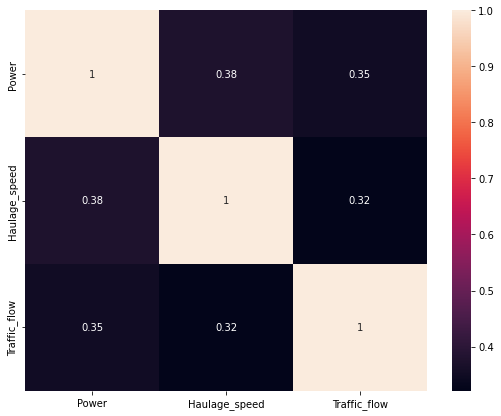

In [ ]:
plt.figure(figsize = (9, 7))
corr = df[['Power', 'Haulage_speed', 'Traffic_flow']].corr()
sns.heatmap(corr, annot = True)

In [ ]:
df['DateTime'] = df.index
df.index = range(df.shape[0])

Дату необходимо разбить по признакам. Далее осуществляем подбор гиперпараметров с помощью GridSearchCV и с помощью алгоритма XGboost обучаем модель, применяя кросс-валидацию



In [ ]:
df["second"] = df.DateTime.dt.second
df["minute"] = df.DateTime.dt.minute
df["hour"] = df.DateTime.dt.hour
df["weekday"] = df.DateTime.dt.weekday 
df["month"] = df.DateTime.dt.month
df["year"] = df.DateTime.dt.year

In [ ]:
df = df.drop(['DateTime'], axis = 1)
df = df.dropna()

In [ ]:
df

,Power,Haulage_speed,Traffic_flow,work_time,target,Power_1,Power_2,Power_3,Power_4,Power_5,second,minute,hour,weekday,month,year
5,484.66,9.07,2484.0,2,288.11,484.66,458.11,458.11,458.11,458.11,25,0,0,4,9,2020
6,484.66,8.37,2489.0,2,288.11,484.66,484.66,458.11,458.11,458.11,30,0,0,4,9,2020
7,484.66,9.41,2502.0,2,288.11,484.66,484.66,484.66,458.11,458.11,35,0,0,4,9,2020
8,469.71,8.88,2510.0,2,243.92,484.66,484.66,484.66,484.66,458.11,40,0,0,4,9,2020
9,469.71,9.06,2509.0,2,243.92,469.71,484.66,484.66,484.66,484.66,45,0,0,4,9,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557926,140.16,9.43,367.0,3,0.00,140.16,141.18,141.18,141.18,141.18,25,16,5,4,11,2020
557927,140.16,5.75,360.0,3,0.00,140.16,140.16,141.18,141.18,141.18,30,16,5,4,11,2020
557928,145.93,13.65,356.0,3,0.00,140.16,140.16,140.16,141.18,141.18,35,16,5,4,11,2020
557929,145.93,13.35,347.0,3,0.00,145.93,140.16,140.16,140.16,141.18,40,16,5,4,11,2020


In [ ]:
X = df.drop(['target'], axis = 1)
y = df.target

In [ ]:
#from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
#from sklearn.model_selection import cross_val_predict

In [ ]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 446340, Test set:111586
Fold:2, Train set: 446341, Test set:111585
Fold:3, Train set: 446341, Test set:111585
Fold:4, Train set: 446341, Test set:111585
Fold:5, Train set: 446341, Test set:111585


In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_model = XGBRegressor()

parameters = {'booster':['gbtree'], 
              'colsample_bylevel': range(0, 1), 
              'colsample_bytree': range(0, 1), 
              'subsample':[0.8, 0.9],
              'gamma':[0.0, 0.1],
              'learning_fate':[0.1, 0.2, 0.3],
              'max_depth': range(7, 11),
              'n_estimators': range(4500, 5500, 2),
              'n_jobs':[-1],
              'seed':[555]}


clf = GridSearchCV(estimator=xgb_model,
                   param_grid=parameters,
                   scoring = 'r2',
                   cv = 5,
                   verbose=True)

clf.fit(X, y)
clf.best_estimator_

Fitting 5 folds for each of 24000 candidates, totalling 120000 fits
[08:05:26] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_fate" } are not used.



KeyboardInterrupt: ignored

In [ ]:
estimator = XGBRegressor(booster = 'gbtree', 
                         colsample_bylevel = 0.5, 
                         colsample_bytree = 0.7, 
                         subsample=0.9,
                         gamma = 0.1,
                         learning_fate = 0.1,
                         max_depth = 10,
                         n_estimators = 6000,
                         n_jobs = -1,
                         seed= 555
                         )
predictions = cross_val_predict(estimator, X, y, cv= kf, verbose = 10)            # Вывод результатов прогноза
predictions = pd.DataFrame({'predictions':predictions})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:59:23] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_fate" } are not used.



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 50.4min remaining:    0.0s


[01:49:48] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_fate" } are not used.



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 98.2min remaining:    0.0s


[02:37:34] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_fate" } are not used.



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 148.4min remaining:    0.0s


[03:27:47] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_fate" } are not used.



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 198.1min remaining:    0.0s


[04:17:31] WARNING: ../src/learner.cc:767: 
Parameters: { "learning_fate" } are not used.



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 247.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 247.6min finished


In [ ]:
predictions

,predictions
0,282.073853
1,285.044373
2,270.055908
3,255.892502
4,240.253891
...,...
557921,6.861469
557922,32.894718
557923,6.130837
557924,-3.805839


In [ ]:
predictions['target'] = df['target']
predictions['DateTime'] = data_time

In [ ]:
predictions.dropna()

,predictions,target,DateTime
5,233.800613,288.11,2020-09-11 00:00:25
6,253.099274,288.11,2020-09-11 00:00:30
7,221.868240,288.11,2020-09-11 00:00:35
8,215.355591,243.92,2020-09-11 00:00:40
9,199.403824,243.92,2020-09-11 00:00:45
...,...,...,...
557921,6.861469,0.00,2020-10-13 06:53:25
557922,32.894718,0.00,2020-10-13 06:53:30
557923,6.130837,0.00,2020-10-13 06:53:35
557924,-3.805839,0.00,2020-10-13 06:53:40


Прогноз составлен, значения выведены. Необходимо узнать, насколько ошибается модель. Для этого нужно построить график с прогнозным и реальным потреблением электроэнергии и, поскольку данных много, для наглядности построим за 10 минутный интервал времени. 

Далее распишем функцию, в которой выведем результаты метрик ошибки. 

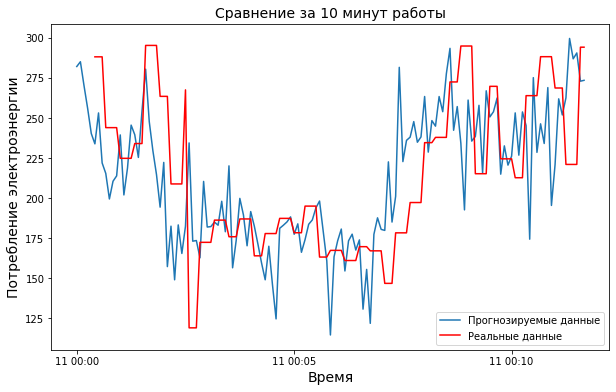

In [ ]:
predictions.index = predictions['DateTime']
predictions = predictions.drop(['DateTime'], axis = 1)
predictions_10_min = predictions[:141]

plt.figure(figsize = (10, 6))
sns.lineplot(data = predictions_10_min['predictions'], label = 'Прогнозируемые данные')
sns.lineplot(data = predictions_10_min['target'], color = 'red', label = 'Реальные данные')
plt.title('Сравнение за 10 минут работы', fontsize = 14)
plt.xlabel('Время', fontsize = 14)
plt.ylabel('Потребление электроэнергии', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
pred_data = predictions
pred_data = pred_data.dropna()
pred_data.index = range(pred_data.shape[0])

In [ ]:
#plt.figure(figsize = (500, 15))
#sns.lineplot(data = df_1['pred'], label = 'Прогнозируемые данные')
#sns.lineplot(data = df_1['target'], color = 'red', label = 'Реальные данные')

In [ ]:
def mist_func(y_true, y_pred):

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  '''Mean squared error'''
  RMSE = sqrt(mean_squared_error(y_true, y_pred)) 

  '''Mean absolute error'''
  MAE = np.mean(np.abs(y_true - y_pred))

  '''MAPE'''
  MAPE = np.mean(np.abs(y_true - y_pred)/(y_true))*100

  '''Коэффициент детерминации r^2'''
  r_2 = round(pred_data.corr().target[1], 3)**2

  '''MAE в процентах'''
  mae_ = (MAE * 100)/y_true.mean()

  data_metrics = pd.DataFrame({'Mean_absolute_error': [MAE],
                               'MAPE': [MAPE],
                               'Коэффициент_детерминации_r^2': [r_2], 
                               'mae_%': [mae_], 
                               'RMSE': [RMSE]})

  return data_metrics

In [ ]:
y_pred = pred_data['predictions']
y_true = pred_data['target']
mist_func(y_true, y_pred)

<ipython-input-30-283e7febed61>:13: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = np.mean(np.abs(y_true - y_pred)/(y_true))*100


,Mean_absolute_error,MAPE,Коэффициент_детерминации_r^2,mae_%,RMSE
0,37.301086,inf,0.687241,22.88284,53.041486
